In [1]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, AveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import relu, sigmoid, softmax

from tensorflow.keras import Input, Model

from tensorflow.keras.constraints import max_norm 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

from tensorflow.keras.datasets import cifar10

import sys
import numpy as np
from termcolor import colored

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib notebook

In [2]:
# load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
# conversion and preprocessing
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train /= 255
x_test /= 255

In [10]:
# custom interface functions
def res_conv2d(X, w, b, kernel_size, strides, padding, groups=1):
    # extract parameters
    (kernel_rows, kernel_cols, channels_in, channels_out) = w.shape
    (batch, rows_in, cols_in, channels_in_) = X.shape
    grouped_channels_out = channels_out//groups
    
    # check parameter compatibility
    assert channels_in * groups == channels_in_
    assert channels_out % groups == 0
    
    # same padding
    if padding == "same":
        rows_offset = kernel_rows//2
        cols_offset = kernel_cols//2
    
        # calculate output dimensions
        rows_out = (rows_in + strides[0] - 1) // strides[0]
        cols_out = (cols_in + strides[1] - 1) // strides[1]
        
    
        # create output buffer
        out = np.zeros((int(batch), int(rows_out), int(cols_out), int(groups*channels_out)))

        # prefill the output with bias
        for i in range(batch):
            for y in range(rows_out):
                for x in range(cols_out):
                    for g in range(groups):
                        gc = g * grouped_channels_out
                        for co in range(grouped_channels_out):
                            out[i, y, x, gc + co] = b[co]

        # convolute
        for i in range(batch):
            for y in range(rows_out):
                for x in range(cols_out):
                    sy = y * strides[0] - rows_offset
                    sx = x * strides[1] - rows_offset
                    for g in range(groups):
                        for co in range(grouped_channels_out):
                            for ci in range(channels_in):
                                for ky in range(sy, sy + kernel_rows):
                                    for kx in range(sx, sx + kernel_cols):
                                        if ky >= 0 and ky < rows_in and kx >= 0 and kx < cols_in:
                                            gc = g * grouped_channels_out
                                            out[i, y, x, gc + co] += X[i, ky , kx, gc + ci] * w[(ky - sy), (kx - sx), ci, co]

        return out
    
    # zero padding
    else:
        rows_out = (rows_in - (kernel_rows - strides[0])) // strides[0]
        cols_out = (cols_in - (kernel_cols - strides[1])) // strides[1]
        
    
        # create output buffer
        out = np.zeros((int(batch), int(rows_out), int(cols_out), int(groups*channels_out)))

        # prefill the output with bias
        for i in range(batch):
            for y in range(rows_out):
                for x in range(cols_out):
                    for g in range(groups):
                        gc = g * grouped_channels_out
                        for co in range(grouped_channels_out):
                            out[i, y, x, gc + co] = b[co]

        # convolute
        for i in range(batch):
            for y in range(rows_out):
                for x in range(cols_out):
                    sy = y * strides[0]
                    sx = x * strides[1]
                    for g in range(groups):
                        for co in range(grouped_channels_out):
                            for ci in range(channels_in):
                                for ky in range(sy, sy + kernel_rows):
                                    for kx in range(sx, sx + kernel_cols):
                                        gc = g * grouped_channels_out
                                        out[i, y, x, gc + co] += X[i, ky , kx, gc + ci] * w[(ky - sy), (kx - sx), ci, co]

        return out

def res_dense(X, w, b):
    # extract parameters
    (batches, size) = X.shape
    (w_s, units) = w.shape
    
    # check parameter compatibility
    assert size == w_s
    
    # create output buffer
    out = np.zeros((batches, units))
        
    # prefill output with bias
    for i in range(batches):
        for j in range(units):
            out[i, j] = b[j]
    
    # matrix multiplikation
    for i in range(batches):
        for j in range(units):
            for k in range(size):
                out[i, j] += X[i, k] * w[k, j]
                
    return out

def res_relu(X):
    # extract parameters
    shape = X.shape
    X = X.flatten()
    
    # create output buffer
    out = np.zeros(X.shape)
    
    # activate all cells
    for i in range(X.shape[0]):
        out[i] = 0 if X[i] <= 0. else X[i]
        
    return out.reshape(shape)

def res_sigmoid(X):
    # extract parameters
    shape = X.shape
    X = X.flatten()
    e = 2.7182818284590452353602874
    
    # create output buffer
    out = np.zeros(X.shape)
    
    # activate all cells
    for i in range(X.shape[0]):
        out[i] = 1 / (1 + e**(-X[i]))
        
    return out.reshape(shape)

def res_softmax(X):
    # extract parameters
    (batches, cells) = X.shape
    e = 2.7182818284590452353602874
    
    # create output buffer
    out = np.zeros(X.shape)
    
    # sum of exponents
    expsums = np.zeros(batches)
    for i in range(batches):
        for j in range(cells):
            expsums[i] += e**X[i, j]
    
    # activate all cells
    for i in range(batches):
        for j in range(cells):
            out[i, j] = e**X[i, j] / expsums[i]
        
    return out

def res_maxpool2d(X, pool_size, strides, padding):
    # extract parameters
    (batch, rows_in, cols_in, channels) = X.shape
    (pool_rows, pool_cols) = pool_size
    (stride_rows, stride_cols) = strides
    
    # same padding
    if padding == "same":    
        # calculate output dimensions
        rows_out = (rows_in + strides[0] - 1) // strides[0]
        cols_out = (cols_in + strides[1] - 1) // strides[1]
        
        # create output buffer
        out = np.zeros((batch, rows_out, cols_out, channels))
        out.fill(sys.float_info.min)

        # pool
        for i in range(batch):
            for y in range(rows_out):
                for x in range(cols_out):
                    sy = y * strides[0]
                    sx = x * strides[1]
                    for c in range(channels):
                        for ky in range(sy, sy + pool_rows):
                            for kx in range(sx, sx + pool_cols):
                                if ky >= 0 and ky < rows_in and kx >= 0 and kx < cols_in:
                                    out[i, y, x, c] = max(out[i, y, x, c], X[i, ky , kx, c])

        return out
    
    # zero padding
    else:
        rows_out = (rows_in - (pool_rows - strides[0])) // strides[0]
        cols_out = (cols_in - (pool_cols - strides[1])) // strides[1]
        
    
        # create output buffer
        out = np.zeros((batch, rows_out, cols_out, channels))

        # pool
        for i in range(batch):
            for y in range(rows_out):
                for x in range(cols_out):
                    sy = y * strides[0]
                    sx = x * strides[1]
                    for c in range(channels):
                        for ky in range(sy, sy + pool_rows):
                            for kx in range(sx, sx + pool_cols):
                                out[i, y, x, c] = max(out[i, y, x, c], X[i, ky , kx, c])

        return out

def res_avgpool2d(X, pool_size, strides, padding):
    # extract parameters
    (batch, rows_in, cols_in, channels) = X.shape
    (pool_rows, pool_cols) = pool_size
    (stride_rows, stride_cols) = strides
    
    # same padding
    if padding == "same":    
        # calculate output dimensions
        rows_out = (rows_in + strides[0] - 1) // strides[0]
        cols_out = (cols_in + strides[1] - 1) // strides[1]
        
        # create output buffer
        out = np.zeros((batch, rows_out, cols_out, channels))

        # pool
        for i in range(batch):
            for y in range(rows_out):
                for x in range(cols_out):
                    sy = y * strides[0]
                    sx = x * strides[1]
                    for c in range(channels):
                        area = 0
                        for ky in range(sy, sy + pool_rows):
                            for kx in range(sx, sx + pool_cols):
                                if ky >= 0 and ky < rows_in and kx >= 0 and kx < cols_in:
                                    out[i, y, x, c] += X[i, ky , kx, c]
                                    area += 1
                        out[i, y, x, c] /= area

        return out
    
    # zero padding
    else:
        rows_out = (rows_in - (pool_rows - strides[0])) // strides[0]
        cols_out = (cols_in - (pool_cols - strides[1])) // strides[1]
        
    
        # create output buffer
        out = np.zeros((batch, rows_out, cols_out, channels))

        # pool
        for i in range(batch):
            for y in range(rows_out):
                for x in range(cols_out):
                    sy = y * strides[0]
                    sx = x * strides[1]
                    for c in range(channels):
                        for ky in range(sy, sy + pool_rows):
                            for kx in range(sx, sx + pool_cols):
                                out[i, y, x, c] += X[i, ky , kx, c]
                        out[i, y, x, c] /= pool_rows * pool_cols

        return out

In [11]:
# build model
def run_model(X, c1, c2, c3, c4, d1, d2):
    X = res_conv2d(X, c1[0], c1[1], kernel_size=(3, 3), strides=(1, 1), padding="same", groups=1)
    X = res_relu(X)
    X = res_maxpool2d(X, pool_size=(2, 2), strides=(2, 2), padding="valid")

    X = res_conv2d(X, c2[0], c2[1], kernel_size=(3, 3), strides=(1, 1), padding="same", groups=1)
    X = res_relu(X)
    X = res_maxpool2d(X, pool_size=(2, 2), strides=(2, 2), padding="valid")

    X = res_conv2d(X, c3[0], c3[1], kernel_size=(3, 3), strides=(1, 1), padding="same", groups=1)
    X = res_relu(X)
    X = res_maxpool2d(X, pool_size=(2, 2), strides=(2, 2), padding="valid")

    X = res_conv2d(X, c4[0], c4[1], kernel_size=(3, 3), strides=(1, 1), padding="same", groups=1)
    X = res_relu(X)
    X = res_maxpool2d(X, pool_size=(2, 2), strides=(2, 2), padding="valid")

    X = X.reshape(X.shape[0], np.prod(X.shape[1:]))
    X = res_dense(X, d1[0], d1[1])
    X = res_relu(X)
    X = res_dense(X, d2[0], d2[1])
    return res_softmax(X)

<IPython.core.display.Javascript object>


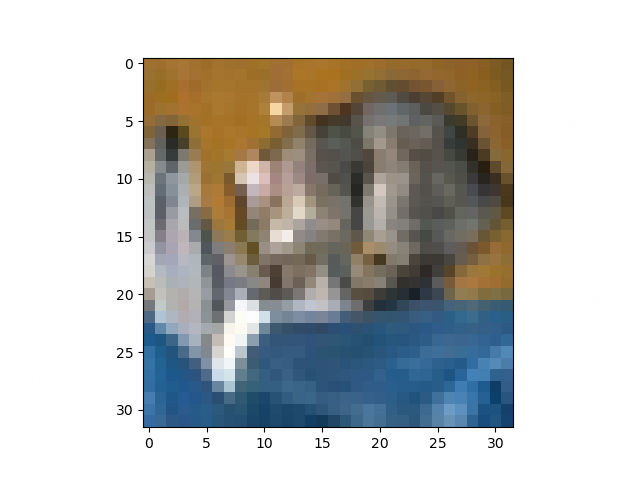

0 -- Reference: cat 	Result: dog


<IPython.core.display.Javascript object>


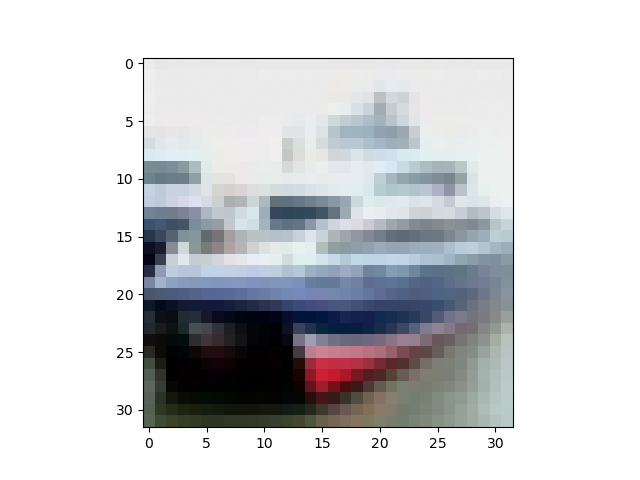

1 -- Reference: ship 	Result: ship


<IPython.core.display.Javascript object>


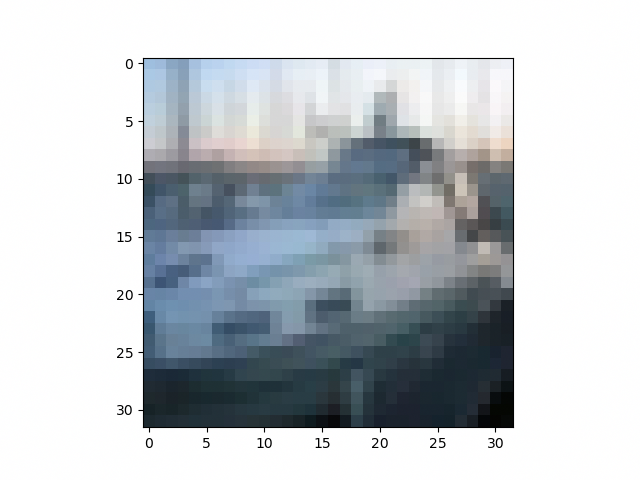

2 -- Reference: ship 	Result: ship


<IPython.core.display.Javascript object>


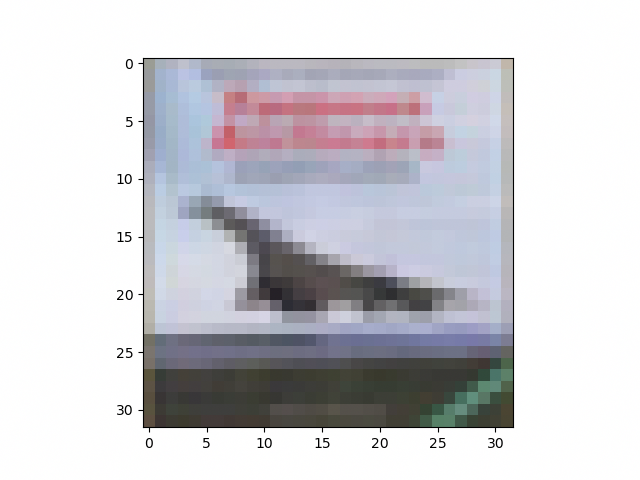

3 -- Reference: airplane 	Result: airplane


<IPython.core.display.Javascript object>


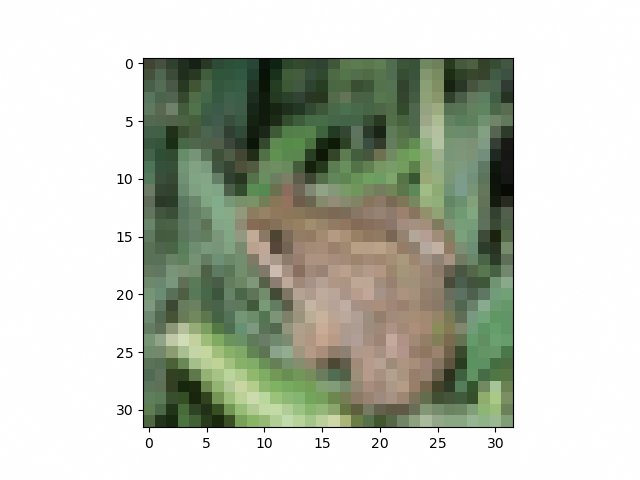

4 -- Reference: frog 	Result: frog


<IPython.core.display.Javascript object>


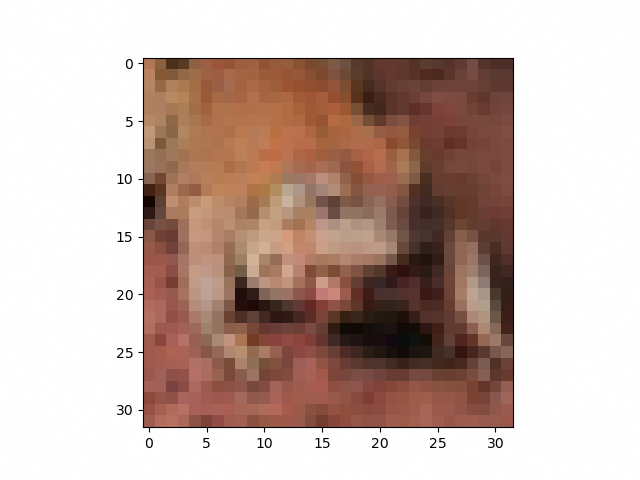

5 -- Reference: frog 	Result: frog


<IPython.core.display.Javascript object>


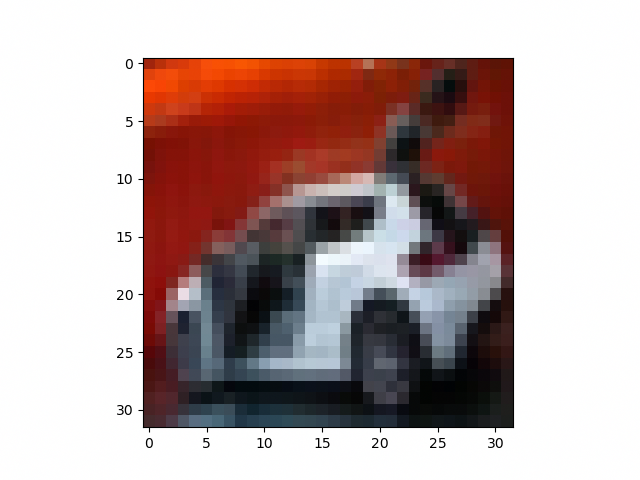

6 -- Reference: automobile 	Result: automobile


<IPython.core.display.Javascript object>


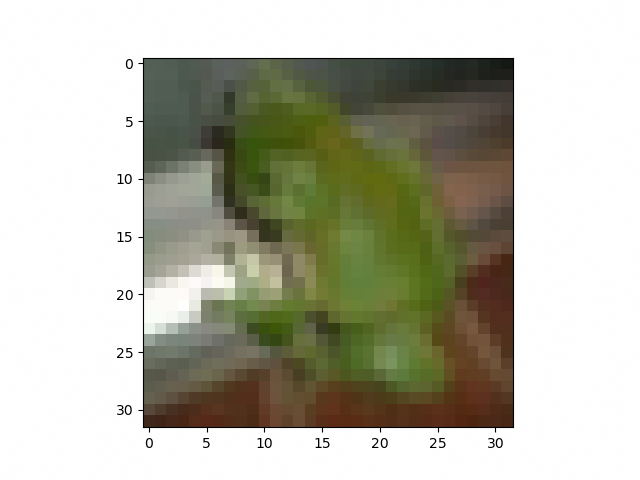

7 -- Reference: frog 	Result: frog


<IPython.core.display.Javascript object>


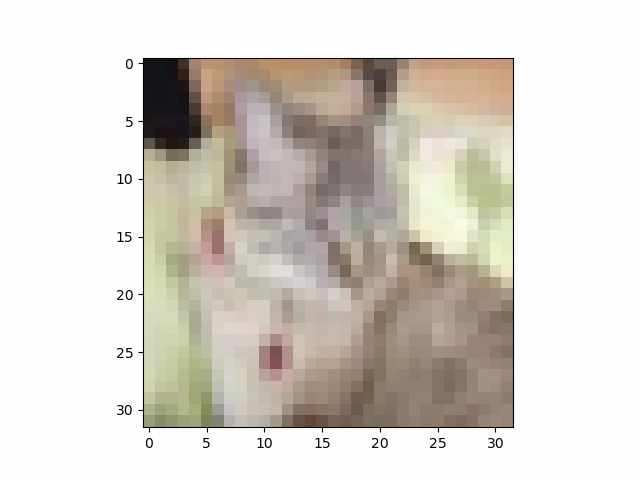

8 -- Reference: cat 	Result: cat


<IPython.core.display.Javascript object>


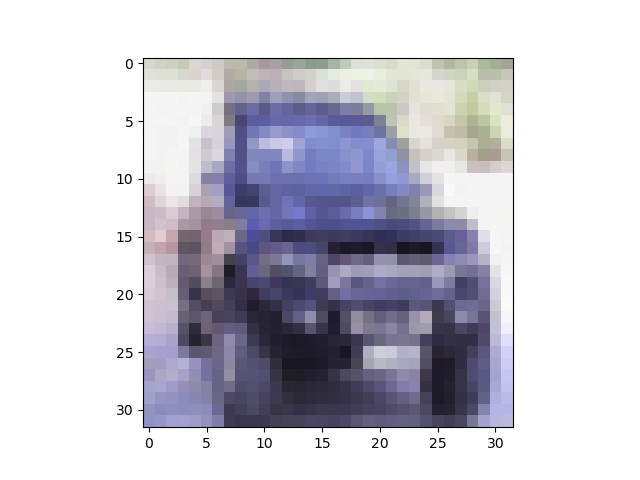

9 -- Reference: automobile 	Result: automobile


In [12]:
# execute model on test data
classes = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

c1 = [np.load("c1w.npy"), np.load("c1b.npy")]
c2 = [np.load("c2w.npy"), np.load("c2b.npy")]
c3 = [np.load("c3w.npy"), np.load("c3b.npy")]
c4 = [np.load("c4w.npy"), np.load("c4b.npy")]
d1 = [np.load("d1w.npy"), np.load("d1b.npy")]
d2 = [np.load("d2w.npy"), np.load("d2b.npy")]

for i in range(10):
    plt.figure(i)
    plt.imshow(x_test[i])
    plt.show()
    
    res = run_model(np.array([x_test[i]]), c1, c2, c3, c4, d1, d2)
    
    color = "green"
    if int(y_test[i]) != np.argmax(res):
        color = "red"
    
    print(i, "-- Reference:", classes[int(y_test[i])], colored("\tResult: " + classes[np.argmax(res)], color))